# Seizure Detection Details
- In this notebook we will discuss the step-by-step procedure that happens in each seizure detection block.
- The main code is in the `seizure_detect.py`.
- Although the components are grouped accordingly, each function has multiple steps.
- The figure below shows the overall operation.;
- We will discuss each step one by one to get a vew of what happens.

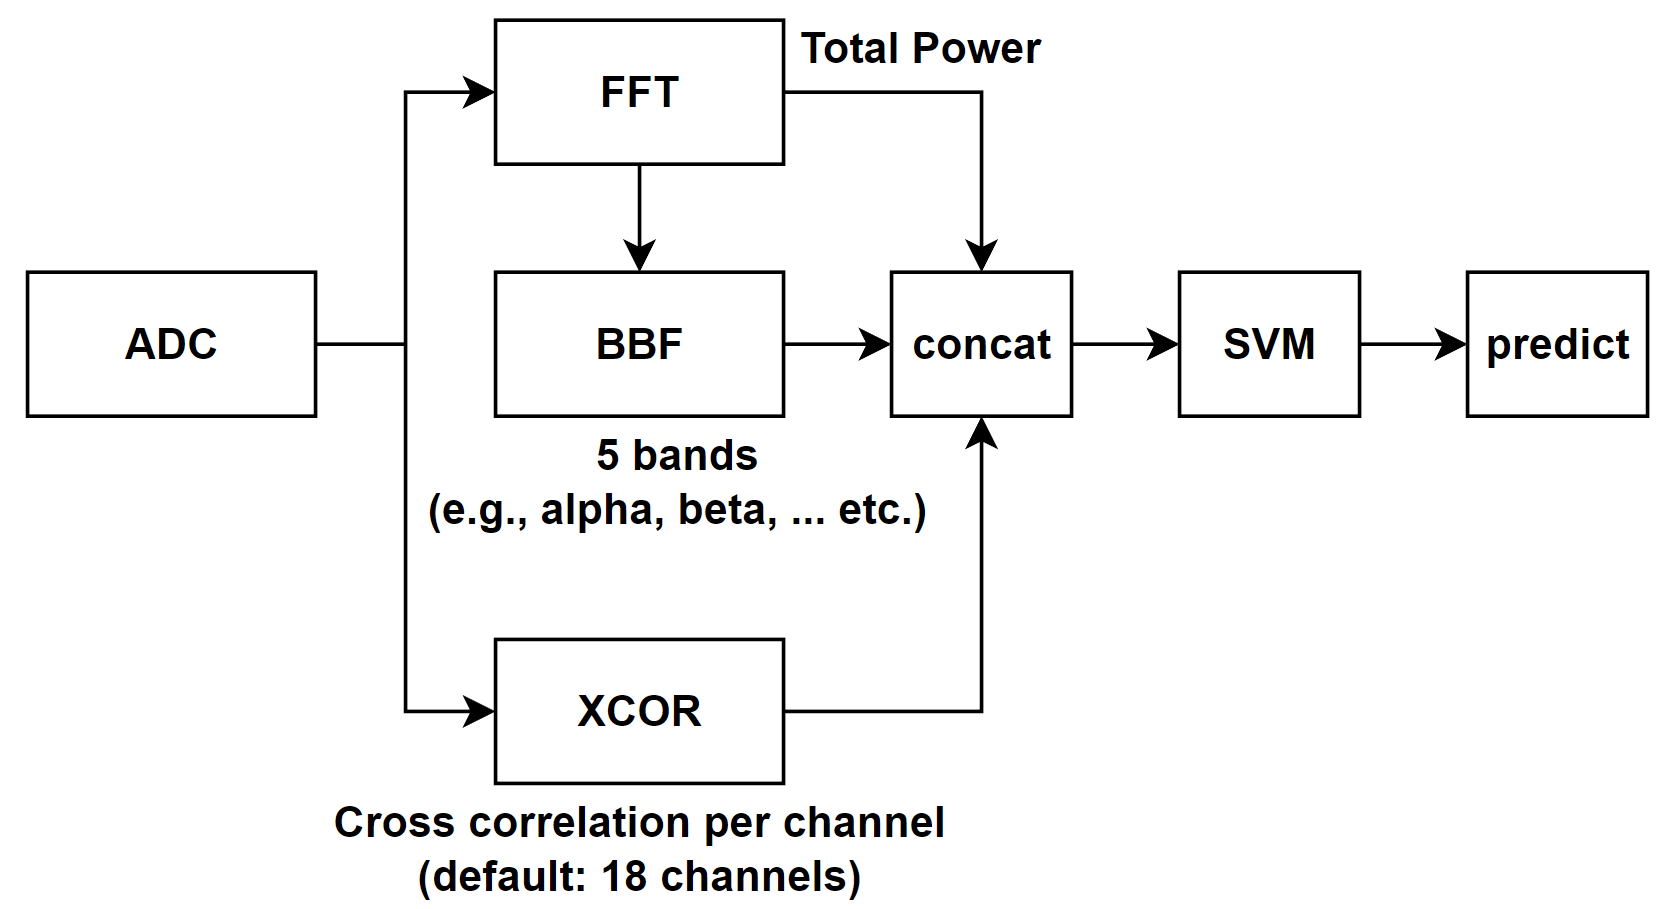

## Step 1: Cut ADC Long Sample into Windows
- The output of the ADC can be a long string of samples.
- In the CHB-MIT data set, the assumes sampling frequency is $f_s = 250 Hz$ and therefore each second has 250 samples.
- Some patient samples can range up to hours, (E.g., patient 1 has an hour of recording) and seizures can last up to a few mins (e.g., 3 mins.)
- Visually the slicing is shown in the figure below.
- This slicing when run on the python code can be treated like a simple pre-process of the original data.
- There are a lot of data overlap because the windows need to be at least 50% overlap for better accuracy.

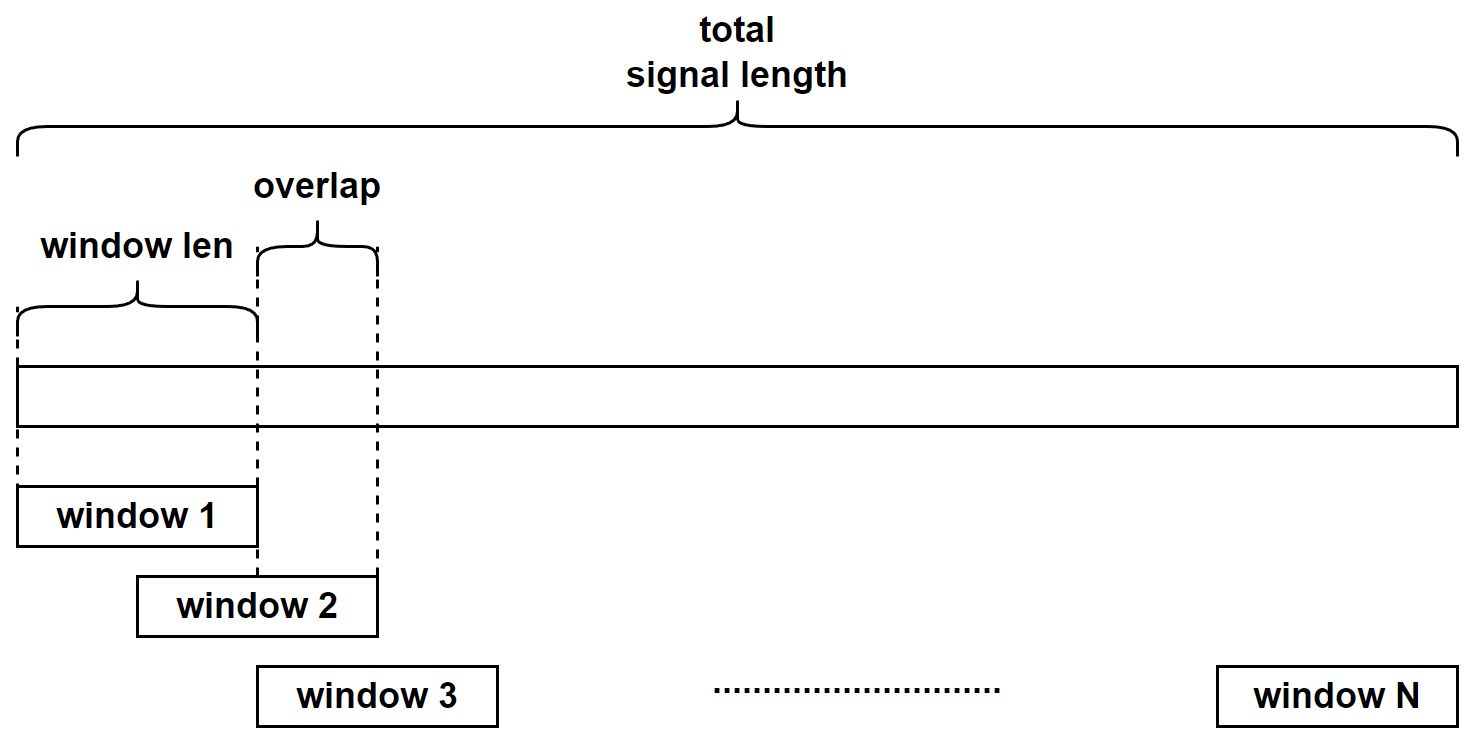

## Step 2: FFT Processing
- The FFT process uses the welch filtering.
- More details can be found in [welch_filter.ipynb](../math/welch_filter.ipynb) inside the `math/`directory.
- Also check the notebook for a more manually detailed process of the welch filter. 
- The ultimate goal of the welch filter is to estimate the power spectrum density (PSD) by averaging the FFT on small segments.
- Here, we summarize the main operations.
### 2a: for every window to be processed, cut it into smaller segments.
$$x_c^{(m)}[n] = x_c[\textrm{start}_m + n], \ n=0,...,L-1 $$
- Take note that the $m$ is the segment number while the $c$ is the channel number.
- You have to do this per channel as well.
### 2b: depending on the segment size $L$, we compute the welch window.
$$w[n] = 0.5 \left( 1 - \cos \left( \frac{2\pi n}{L-1} \right) \right), \ \ n=0, ..., L-1 $$
- Take note that the values are fixed so we kind of pre-compute this and store it somewhere.
- Think of it like fixed weights.
- Then we also precalculate the power of the welch window:
$$ U = \sum_{n=0}^{L-1} w[n]^2 $$
- This power is later used to normalize the power.
### 2c: Pre-calculate the number of bins
$$ f_k = \frac{k}{L}f_s, \ \ k=0,...,\lfloor\frac{L}{2}\rfloor $$
- Note that this is also fixed.
### 2d: Detrend the samples based on the mean on every segment.
- This allows us to take out the low-frequency mean so that the FFT is based more on the variations.
$$ \tilde{x}_c^{(m)}[n] = x_c^{(m)}[n] - \frac{1}{L} \sum_{n=0}^{L-1}x_c^{(m)}[n]$$
- Take note that the variable $m$ is the segment number based on the segmentation in step 2a.
### 2e: Apply the Hanning window.
$$x_{w,c}^{(m)}[n] = \tilde{x}_c^{(m)} \cdot w[n] $$
### 2f: FFT each windowed segment one-sided style.
$$X_c^{(m)}[k] =  \sum_{n=0}^{L-1} x_{w,c}^(m)[n]e^{\frac{-j2\pi kn}{L}}$$
- Technically this is done only for $k=0,...,L/2$ because the bins fold in the 2nd half.
### 2g: Convert FFT magnitudes to a PSD
$$ P_{xx,c}^{(m)}[k] = \frac{|X_c^{(m)}[k]|^2}{f_s U}$$
- Again note that this is done for every segment, and every channel!
### 2h: One-sided correction
- This is a minor tuning for the data because you need to double all the bins except for the nyquist bin at $L/2$ and at DC when $k=0$
```python
    if L % 2 == 0:
        Pxx[:, 1:-1] *= 2.0
    else:
        Pxx[:, 1:] *= 2.0
```
### 2i: Average the power across all segments.
$$ \hat{P}_{xx}[k] = \frac{1}{M} \sum_{m=1}^M P_{xx}^{(m)}[k] $$
- Observe that it is averaging the power per bin $k$ across all segments $m$
- This is the PSD which will later be used for BBF (see below)

### 2j: Get total log power per channel
- This is one of the first features needed before getting into the SVM
- You need to sum up all the powers across the entire PSD using the trapezoid function as an estimate of the area under the curve:
$$\int \hat{P}_{xx} dk \approx \sum_{k=0}^{L-2} \frac{\hat{P}_{xx}[k] + \hat{P}_{xx}[k+1]}{2} \cdot \left( f_{k+1} - f_k \right) $$
- The trapezoid explanation can be found in [tra](../math/trapezoid.ipynb)
- Then, finally get the log of it:
$$ \log \left(\int \hat{P}_{xx} dk \right)$$
- For every channel you get one total log PSD.

### Visualization of process
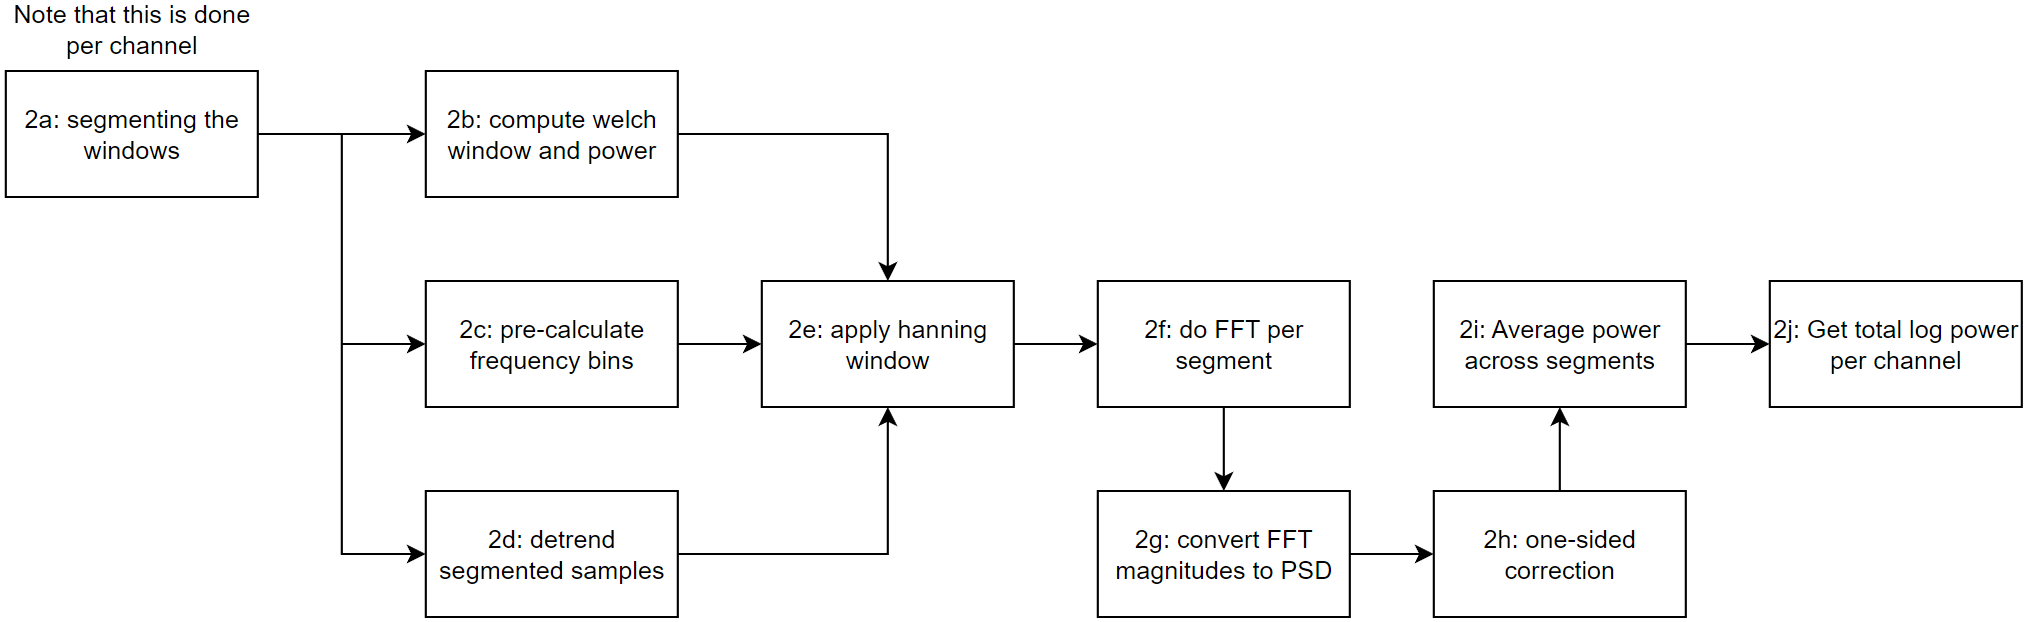


## Step 3: Base Band Filtering (BBF)
- After doing the FFT we can proceed to base band filtering
- There are 5 different bands for EEG. It is summarized in the list below:
```python
    EEG_BANDS = {
        "delta": (0.5, 4.0),
        "theta": (4.0, 8.0),
        "alpha": (8.0, 13.0),
        "beta": (13.0, 30.0),
        "gamma": (30.0, 45.0),
    }
```
- The dictionary keys are the bands, and the value tuples are the frequency bands.
- Here, you also use the same trapezoidal function:
$$\int_{f\textrm{low}}^{f\textrm{high}} \hat{P}_{xx} dk \approx \sum_{k=\textrm{low}}^{\textrm{high}} \frac{\hat{P}_{xx}[k] + \hat{P}_{xx}[k+1]}{2} \cdot \left( f_{k+1} - f_k \right) $$
- However, the bounds of the integral and hence the sum of the limits of the bands of interest.
- The output are 5 band powers.

## Step 4: Cross-Correlation
- Cross correlation, in a nutshell, is simply measuring correlation on different channel pairs.
- The number of pairs is $ C \choose 2$ where $C$ is number of channels.
- In the BCI example we have 18 channels so that's roughly $ {18 \choose 2} = 153$
- You can see more details on cross correlation in [cross_correlation.ipynb](../math/cross_correlation.ipynb).
- There are several steps though.

### Step 4a: Detrending the samples.
- Similar to the detrend in FFT, we subtract the mean of the window per channel.
$$ \tilde{x}[t] = x[t] - \frac{1}{L} \sum_{n=0}^{L-1}x_t$$

### Step 4b: Calculate the normalization factor.
- Do this for each time series pair.
$$ ||\tilde{x}||_2 = \sqrt{\sum_L \tilde{x}[t]^2}$$
- Then you get the product as:
$$ ||\tilde{x}_i||_2 \cdot ||\tilde{x}_j||_2 $$

### Step 4c: Calculate the correlation.
$$ \textrm{corr}(x_i,x_j)[l] = \sum_t x_i[t] \cdot x_j[t+l] $$

### Step 4d: Normalize it to get actual normalized correlation.
- Take note that the correlation is like a sliding operation.
$$ r[l] = \frac{\sum_t x_i[t] \cdot x_j[t+l]}{||\tilde{x}_i||_2 \cdot ||\tilde{x}_j||_2} $$

### Visualization of Process
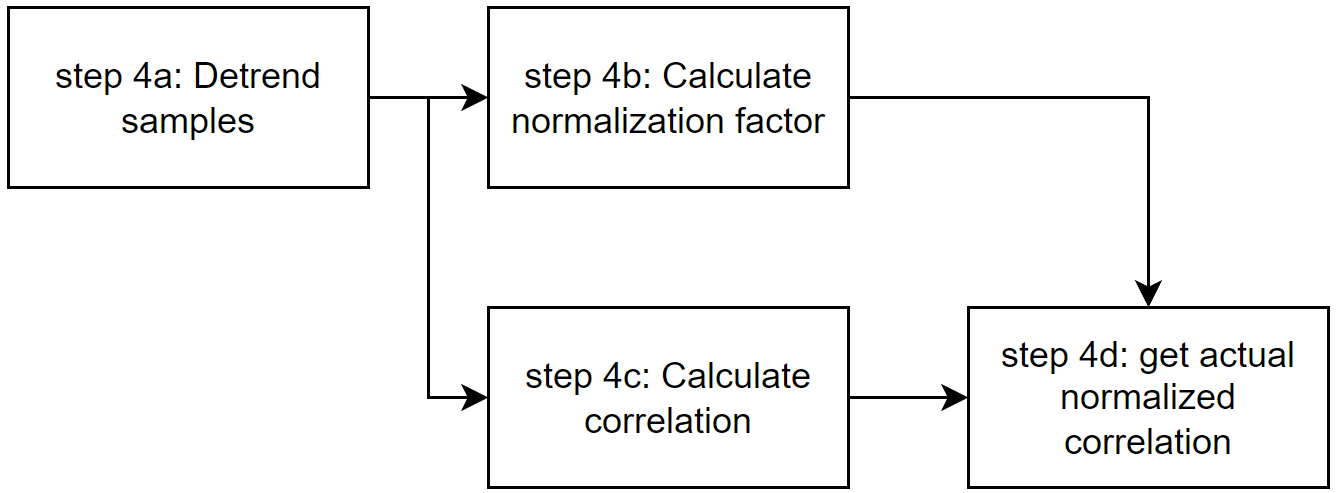

## Step 5: Concatenation
- The concatenation step is a simple concatenation of data.
- The first set of feature is the total PSD power taken after the output of the PSD. So it's simply a trapezoidal area under the curve.
- The second set of feature is the 5 base bands.
- Therefore, the combination of the output of FFT and BBF is 6 features (1 total power and 5 base bands) multiplied by the number of channels:
$$ N_{ch} \cdot (1+5) = 6N_{ch}$$
- Then the cross-correlation has $N_{ch} \choose 2$ combinations. 
- Note that in some examples they only extract the first few channels. Sometimes they only extract 6 channels.
- In total we have $$ N_{\textrm{feat}} =  6N_{ch} + {N_{ch} \choose 2}$$ features to be fed to the SVM.

## Step 6: SVM prediction
- The SVM is a simple dot product:
$$\hat{y} = w^Tx + b $$
- Where the $(w,x,b) \in \mathbb{R}^{ N_{\textrm{feat}}}$